## Подключение библиотек

Подключим сторонние библиотеки:

- `numpy` для удобной работы с данными
- `matplotlib` для рисование графиков

In [66]:
import numpy as np
import matplotlib.pyplot as plt  

Также подключим некоторые стандартные библиотеки

In [67]:
from pprint import pprint
from collections import Counter

## Импорт данных

Загрузим **файлы данных** и проверим корректно ли они загрузились

In [68]:
data = []
for i in range(3):
    filename = f'set_{i + 1}.csv'
    try:
        cur_data = np.loadtxt(filename, delimiter=',')
        data.append(cur_data)
    except FileNotFoundError:
        print(f"Ошибка: Файл {filename} не найден")
    except ValueError:
        print(f"Ошибка: Некорректный формат данных в файле {filename}")

pprint(data)

[array([3., 1., 1., ..., 1., 1., 3.], shape=(100000,)),
 array([ 90.547448,  80.548716,  92.992958, ...,   9.088514, 328.988096,
        84.872411], shape=(10000,)),
 array([0.002163, 0.023507, 0.067606, ..., 0.109763, 0.041012, 0.040421],
      shape=(100000,))]


## Обнаружение и удаления выбросов

Для удаления выбросов будем использовать медиану и медианное абсолютное отклонение (MAD). Напишем функцию реализующую это.

In [69]:
def remove_outliers_mad(data: np.ndarray, threshold: float = 3) -> np.ndarray:
    median = np.median(data)
    absolute_deviation = np.abs(data - median)
    
    mad = np.median(absolute_deviation)
    
    lower_bound = median - threshold * mad
    upper_bound = median + threshold * mad
    
    filtered_data = data[(data >= lower_bound) & (data <= upper_bound)]
    
    return filtered_data

Затем для каждого набора применим эту функцию.

In [70]:
for i in range(len(data)):
    data[i] = remove_outliers_mad(data[i])
pprint(data)

[array([3., 1., 1., ..., 1., 1., 3.], shape=(82637,)),
 array([ 90.547448,  80.548716,  92.992958, ..., -47.738661,   9.088514,
        84.872411], shape=(9421,)),
 array([0.002163, 0.023507, 0.067606, ..., 0.109763, 0.041012, 0.040421],
      shape=(87395,))]


## Анализ данных

Для начала нам нужно найти вероятность для каждого элемента из предоставленных данных. Поэтому напишем функцию `calculate_distribution` и найдем вероятности для каждого набора.

In [71]:
def calculate_distribution (numbers: np.ndarray) -> dict[float, float]:    
    frequency = Counter(numbers)
    total_count = len(numbers)
    distribution = {num: count / total_count for num, count in frequency.items()}
    return distribution


distributions = [calculate_distribution(numbers) for numbers in data]

Теперь давайте напишем функцию нахождения **математического ожидания** и **дисперсии**. Назовем эти функции `calculate_mean` и `calculate_variance`

In [72]:
def calculate_mean(distribution: dict) -> float:    
    return sum(num * prob for num, prob in distribution.items())


def calculate_variance(distribution: dict, mean: float | None = None) -> float:
    if mean is None:
        mean = calculate_mean(distribution)
    return sum(prob * (num - mean) ** 2 for num, prob in distribution.items())


means = [calculate_mean(distribution) for distribution in distributions]
variances = [calculate_variance(distribution, mean) for distribution, mean in 
             zip(distributions, means)]
print(f"Математическое ожидание:", means)
print(f"Дисперсия:", variances)

Математическое ожидание: [np.float64(2.3273836175078957), np.float64(18.87155596826238), np.float64(0.08888030923965883)]
Дисперсия: [np.float64(1.710456134805733), np.float64(5683.916395682249), np.float64(0.0047720008911223254)]


Построим гистограммы для заданных наборов данных

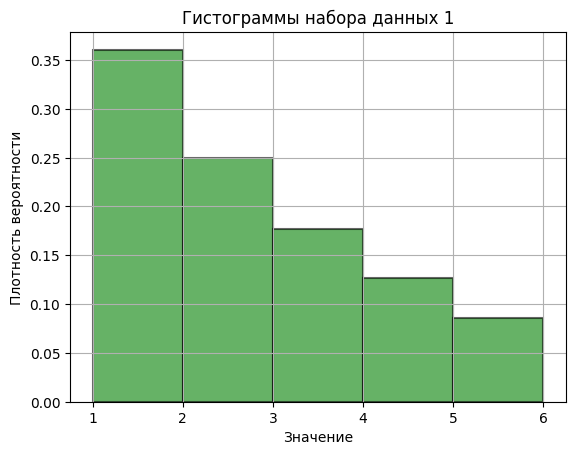

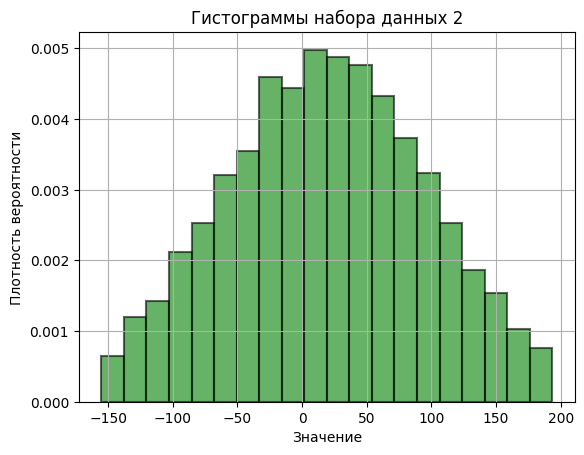

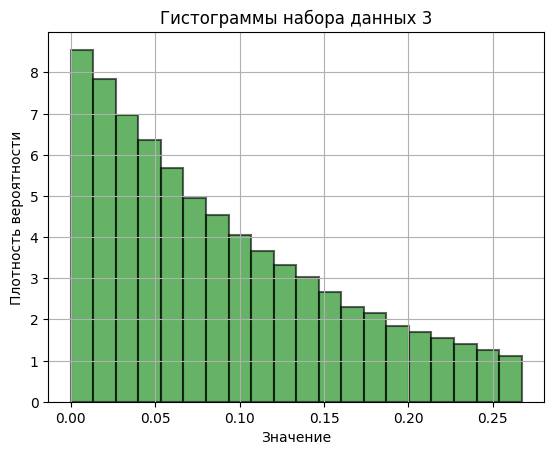

In [73]:
def plot_histograms(numbers: np.ndarray, title: str):
    counter = Counter(numbers)
    if len(counter) < 19:
        bins = np.arange(np.min(numbers), np.max(numbers) + 2)
    else:
        bins = 20
    plt.hist(numbers, bins=bins, density=True, alpha=0.6, color='green',
             edgecolor='black', linewidth=1.5)
    
    plt.title(title)
    plt.xlabel('Значение')
    plt.ylabel('Плотность вероятности')
    plt.grid()
    plt.show()

for i, cur_data in enumerate(data):
    plot_histograms(cur_data, f'Гистограммы набора данных {i + 1}')


## Теоретические распределения

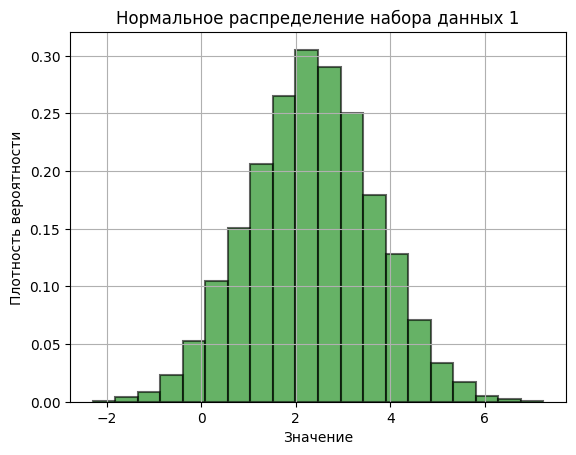

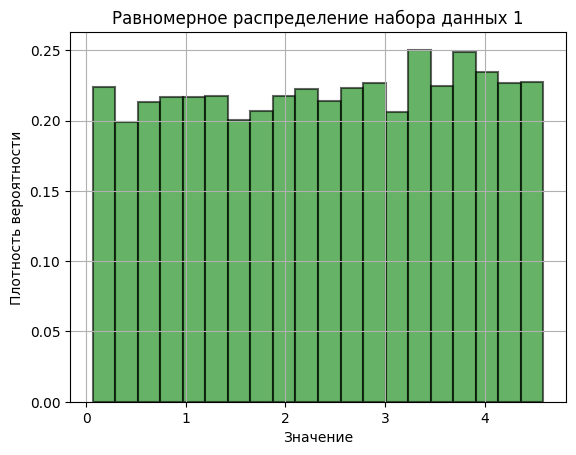

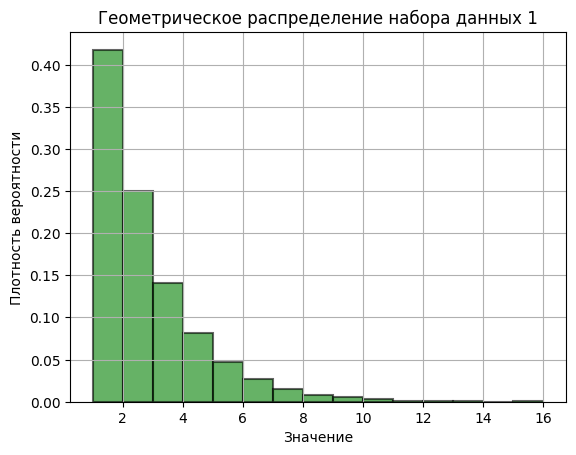

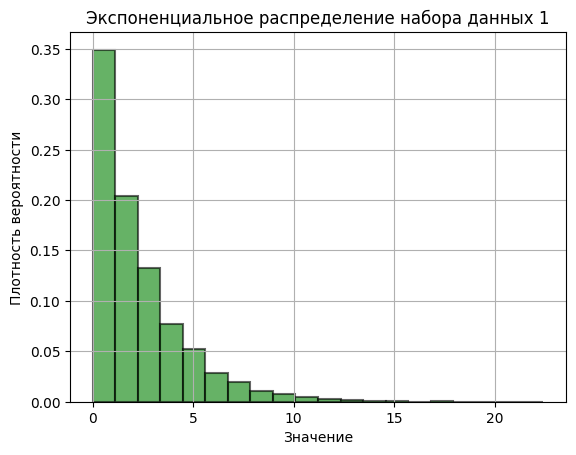

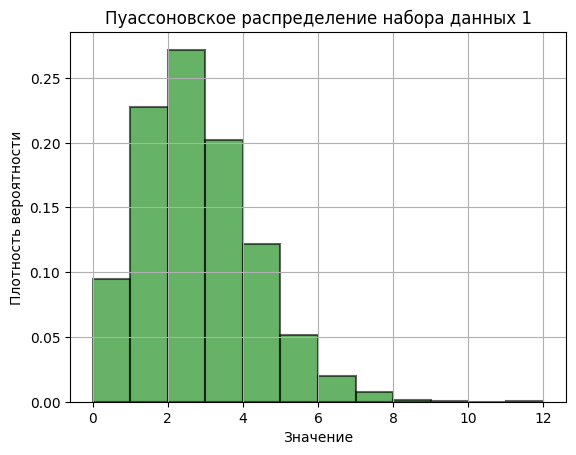

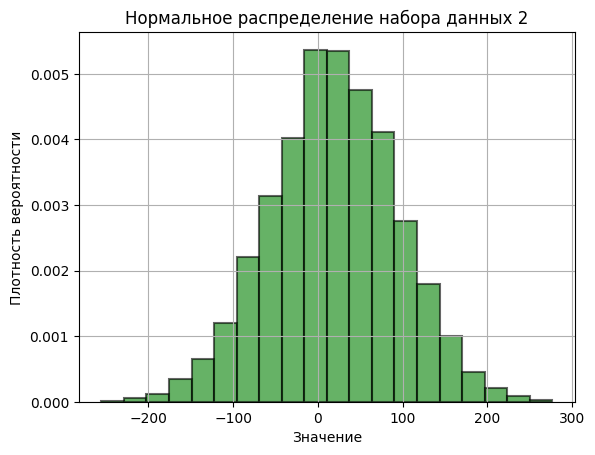

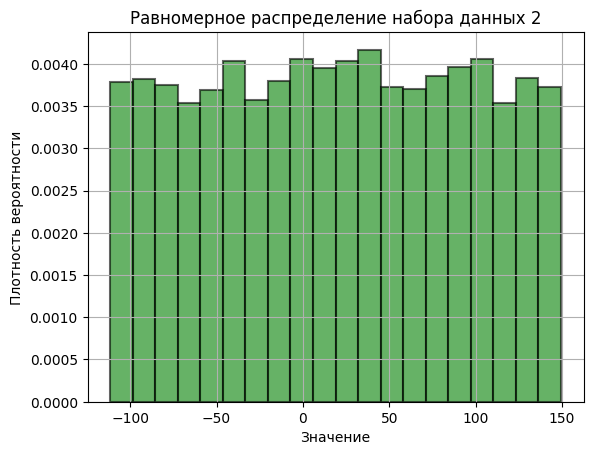

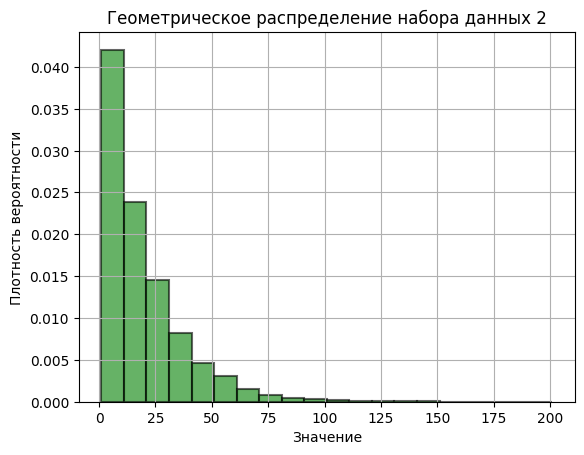

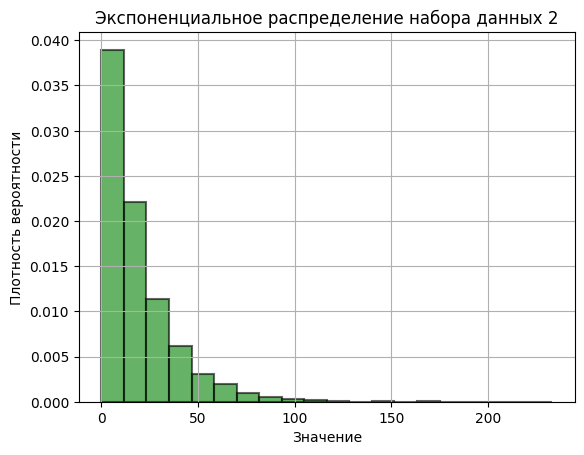

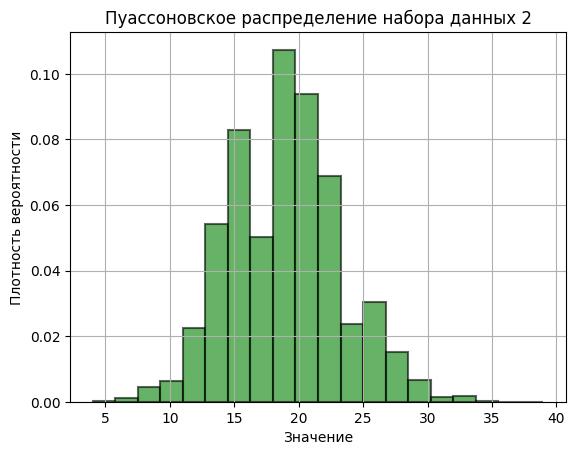

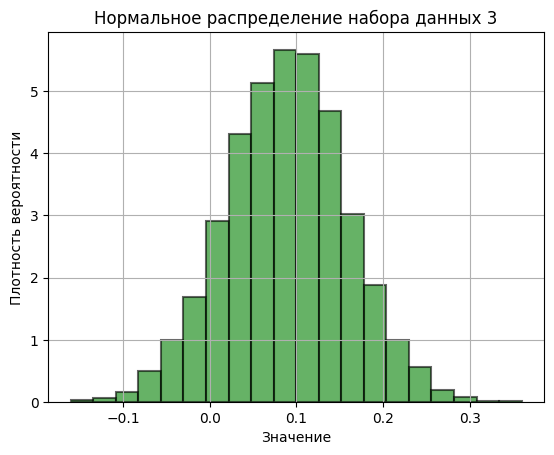

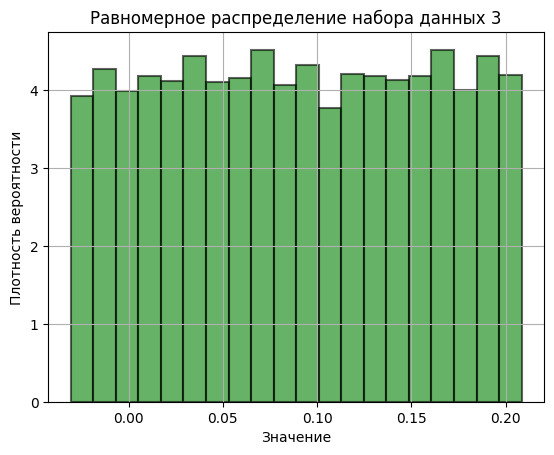

Геометрическое распределение не может быть построено с заданным параметром математического
ожидания. Посколько вероятность успешного события в таком случае больше 1 (11.251085966674328)


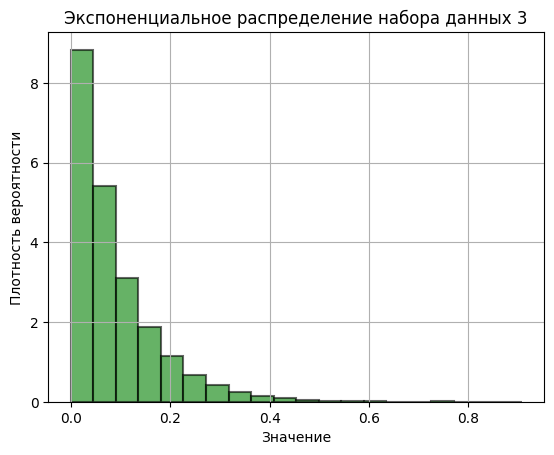

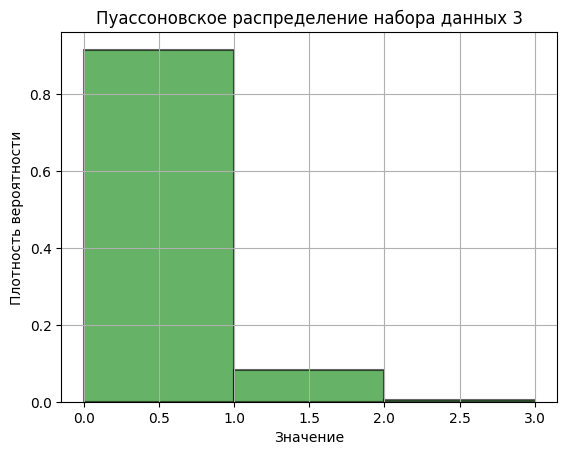

In [74]:
def geometric_distribution(mean: float, size: int) -> np.ndarray | None:
    p = 1 / mean
    if p > 1:
        return None
    log_q = np.log(1 - p)
    u = random_uniform(0, 1, size)
    random_numbers = np.ceil(np.log(1 - u) / log_q)
    return random_numbers


def random_uniform(low: float, high: float, size: int) -> np.ndarray:
    random_numbers = [low + (high - low) * np.random.rand() for _ in range(size)]
    return np.array(random_numbers)


def uniform_distribution(mean: float, variance: float, size: int) -> np.ndarray:
    low = mean - np.sqrt(3 * variance)
    high = mean + np.sqrt(3 * variance)

    return random_uniform(low, high, size)


def box_muller():
    u1 = np.random.rand()
    u2 = np.random.rand()
    
    r = np.sqrt(-2 * np.log(1 - u1))
    theta = 2 * np.pi * u2

    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return x, y


def normal_distribution(mean: float, variance: float, size: int) -> np.ndarray:
    std_dev = np.sqrt(variance)
    random_numbers = np.zeros(size)

    for i in range(size // 2):
        x, y = box_muller()

        random_numbers[2*i] = x * std_dev + mean
        random_numbers[2*i + 1] = y * std_dev + mean
    
    if size % 2 != 0:
        x, y = box_muller()
        random_numbers[-1] = x * std_dev + mean
    return random_numbers


def exponential_distribution(mean: float, size: int):
    u = random_uniform(0, 1, size)
    random_numbers = -mean * np.log(1 - u)
    return random_numbers


def poisson_distribution(lam: float, size: int) -> np.ndarray:
    random_numbers = np.zeros(size)
    L = np.exp(-lam)
    
    for i in range(size):
        u = np.random.rand()
        k = 0
        cur_term = 1
        sum = cur_term
        while L * sum < u:
            k += 1
            cur_term *= lam / k
            sum += cur_term
        
        random_numbers[i] = k
    
    return random_numbers


def binomial_distribution(size: int) -> np.ndarray:
    random_numbers = np.zeros(size)

    return random_numbers


SIZE = 10000

for i in range(len(data)):
    norm_distribution = normal_distribution(means[i], variances[i], SIZE)
    uni_distribution = uniform_distribution(means[i], variances[i], SIZE)
    geo_distribution = geometric_distribution(means[i], SIZE)
    exp_distribution = exponential_distribution(means[i], SIZE)
    pois_distribution = poisson_distribution(means[i], SIZE)

    plot_histograms(norm_distribution, f"Нормальное распределение набора данных {i + 1}")
    plot_histograms(uni_distribution, f"Равномерное распределение набора данных {i + 1}")
    if geo_distribution is None:
        print("Геометрическое распределение не может быть построено с заданным параметром математического")
        print(f"ожидания. Посколько вероятность успешного события в таком случае больше 1 ({1 / means[i]})")
    else:
        plot_histograms(geo_distribution, f"Геометрическое распределение набора данных {i + 1}")
    plot_histograms(exp_distribution, f"Экспоненциальное распределение набора данных {i + 1}")
    plot_histograms(pois_distribution, f"Пуассоновское распределение набора данных {i + 1}")

## Визуальное сравнение и выводы

Для начала напишем функцию, которая рисует две гистограммы на одном холсте: 
1. Гистограмма с эмпирическими данными
2. Гистограмма с теоретичесой моделью


In [75]:
def plot_theoretical_and_empirical_histogram(
        empirical_data: np.ndarray,
        theoretical_data: np.ndarray,
        title: str
    ):
    counter_empirical = Counter(empirical_data)
    counter_theoretical = Counter(theoretical_data)

    min_val = min(np.min(empirical_data), np.min(theoretical_data))
    max_val = max(np.max(empirical_data), np.max(theoretical_data))

    if len(counter_empirical) < 15 or len(counter_theoretical) < 15:
        bins = np.arange(min_val, max_val + 2)
    else:
        bins = 20
    
    plt.hist(empirical_data, bins=bins, density=True, alpha=0.6, color='yellow',
             edgecolor='black', linewidth=1.5, label="Эмпирические данные")
    
    plt.hist(theoretical_data, bins=bins, density=True, alpha=0.6, color='blue',
             edgecolor='black', linewidth=1.5, label="Теоретическая модель")

    plt.title(title)
    plt.xlabel('Значение')
    plt.ylabel('Плотность вероятности')
    plt.grid(True)
    plt.legend()
    plt.show()

Первый набор данных похож на геометрическое и на экспоненциальное распределения. Давайте сравним этот набор данных с его теоретическими моделями

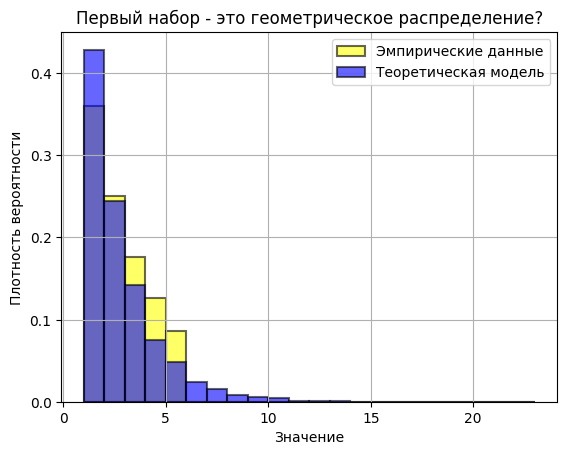

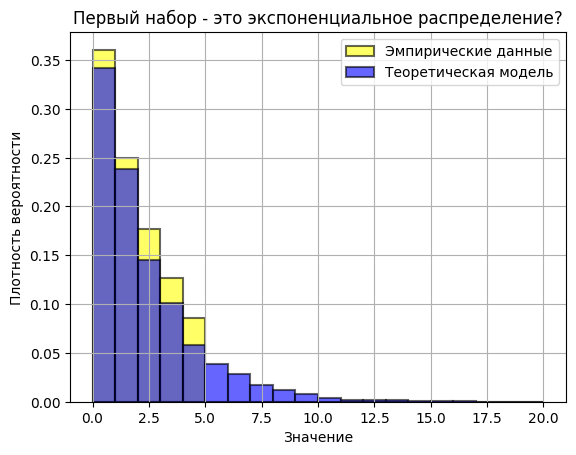

In [76]:
theor_geo_distribution = geometric_distribution(means[0], SIZE)
plot_theoretical_and_empirical_histogram(
    data[0],
    theor_geo_distribution,
    "Первый набор - это геометрическое распределение?"
)

theor_exp_distribution = exponential_distribution(means[0], SIZE)
plot_theoretical_and_empirical_histogram(
    data[0],
    theor_exp_distribution,
    "Первый набор - это экспоненциальное распределение?"
)

Исходя из данных графиков я делаю вывод, что первый набор данных подчиняется экспоненциальному закону распределения.

Второй набор данных больше всего напоминает нормальное распределение. Давайте это проверим, сравнив теоретическое распределение с гистограммой.

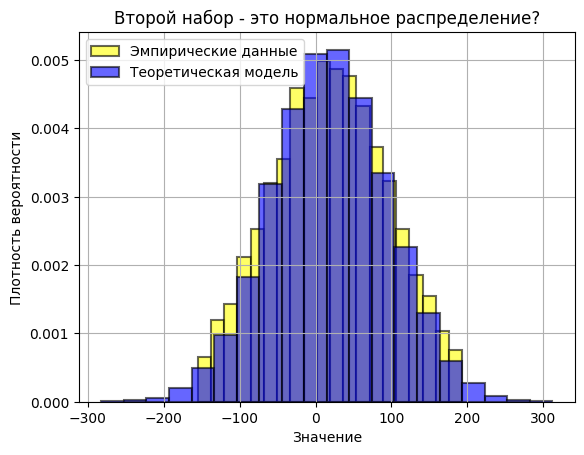

In [77]:
theor_norm_distribution = normal_distribution(means[1], variances[1], SIZE)
plot_theoretical_and_empirical_histogram(
    data[1],
    theor_norm_distribution,
    "Второй набор - это нормальное распределение?"
)


Действительно, второй набор подчиняется нормальному распределению.

Третий набор данных напоминает экспоненциальное распределение. Проверим это.

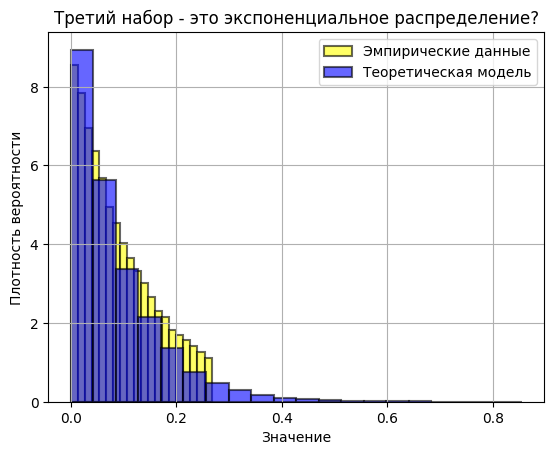

In [78]:
theor_exp_distribution = exponential_distribution(means[2], SIZE)
plot_theoretical_and_empirical_histogram(
    data[2],
    theor_exp_distribution,
    "Третий набор - это экспоненциальное распределение?"
)

Действительно, третий набор подчиняется экспоненциальному распределению.